In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib
import warnings
warnings.filterwarnings('ignore')
import pickle

In [2]:
train_df = pd.read_csv("Paitients_Files_Train.csv")
test_df = pd.read_csv("Paitients_Files_Test.csv")

In [3]:
train_df.head()

ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive

In [5]:
test_df.head()

ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance
0  ICU200609    1  109  38  18  120  23.1  0.407   26          1
1  ICU200610    1  108  88  19    0  27.1  0.400   24          1
2  ICU200611    6   96   0   0    0  23.7  0.190   28          1
3  ICU200612    1  124  74  36    0  27.8  0.100   30          1
4  ICU200613    7  150  78  29  126  35.2  0.692   54          0

In [6]:
# Define new column names for better understanding
new_column_names = {
    'PRG': 'Plasma_glucose',
    'PL': 'Blood_Work_Result_1',
    'PR': 'Blood_Pressure',
    'SK': 'Blood_Work_Result_2',
    'TS': 'Blood_Work_Result_3',
    'M11': 'Body_mass_index',
    'BD2': 'Blood_Work_Result_4'
}

train_df.rename(columns=new_column_names, inplace=True)
test_df.rename(columns=new_column_names, inplace=True)

In [7]:
train_df.columns

Index(['ID', 'Plasma_glucose', 'Blood_Work_Result_1', 'Blood_Pressure',
       'Blood_Work_Result_2', 'Blood_Work_Result_3', 'Body_mass_index',
       'Blood_Work_Result_4', 'Age', 'Insurance', 'Sepssis'],
      dtype='object')

In [8]:
print("The train dataset has", train_df.shape[0],"rows and", train_df.shape[1], "columns")
print("The test dataset has", test_df.shape[0], "rows and", test_df.shape[1], "columns")

The train dataset has 599 rows and 11 columns
The test dataset has 169 rows and 10 columns


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   599 non-null    object 
 1   Plasma_glucose       599 non-null    int64  
 2   Blood_Work_Result_1  599 non-null    int64  
 3   Blood_Pressure       599 non-null    int64  
 4   Blood_Work_Result_2  599 non-null    int64  
 5   Blood_Work_Result_3  599 non-null    int64  
 6   Body_mass_index      599 non-null    float64
 7   Blood_Work_Result_4  599 non-null    float64
 8   Age                  599 non-null    int64  
 9   Insurance            599 non-null    int64  
 10  Sepssis              599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   169 non-null    object 
 1   Plasma_glucose       169 non-null    int64  
 2   Blood_Work_Result_1  169 non-null    int64  
 3   Blood_Pressure       169 non-null    int64  
 4   Blood_Work_Result_2  169 non-null    int64  
 5   Blood_Work_Result_3  169 non-null    int64  
 6   Body_mass_index      169 non-null    float64
 7   Blood_Work_Result_4  169 non-null    float64
 8   Age                  169 non-null    int64  
 9   Insurance            169 non-null    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 13.3+ KB


In [11]:
train_df.describe(include = "all").T

count unique        top freq        mean         std  \
ID                     599    599  ICU200010    1         NaN         NaN   
Plasma_glucose       599.0    NaN        NaN  NaN    3.824708    3.362839   
Blood_Work_Result_1  599.0    NaN        NaN  NaN  120.153589   32.682364   
Blood_Pressure       599.0    NaN        NaN  NaN   68.732888   19.335675   
Blood_Work_Result_2  599.0    NaN        NaN  NaN   20.562604   16.017622   
Blood_Work_Result_3  599.0    NaN        NaN  NaN   79.460768  116.576176   
Body_mass_index      599.0    NaN        NaN  NaN   31.920033    8.008227   
Blood_Work_Result_4  599.0    NaN        NaN  NaN    0.481187    0.337552   
Age                  599.0    NaN        NaN  NaN   33.290484   11.828446   
Insurance            599.0    NaN        NaN  NaN    0.686144    0.464447   
Sepssis                599      2   Negative  391         NaN         NaN   

                       min    25%    50%    75%    max  
ID                     NaN    NaN    NaN    NaN    NaN  
Plasma_glucose         0.0    1.0    3.0    6.0   17.0  
Blood_Work_Result_1    0.0   99.0  116.0  140.0  198.0  
Blood_Pressure         0.0   64.0   70.0   80.0  122.0  
Blood_Work_Result_2    0.0    0.0   23.0   32.0   99.0  
Blood_Work_Result_3    0.0    0.0   36.0  123.5  846.0  
Body_mass_index        0.0   27.1   32.0  36.55   67.1  
Blood_Work_Result_4  0.078  0.248  0.383  0.647   2.42  
Age                   21.0   24.0   29.0   40.0   81.0  
Insurance              0.0    0.0    1.0    1.0    1.0  
Sepssis                NaN    NaN    NaN    NaN    NaN

In [12]:
train_df.nunique()

ID                     599
Plasma_glucose          17
Blood_Work_Result_1    129
Blood_Pressure          44
Blood_Work_Result_2     51
Blood_Work_Result_3    164
Body_mass_index        233
Blood_Work_Result_4    437
Age                     50
Insurance                2
Sepssis                  2
dtype: int64

In [13]:
# Checking for missing values
round(train_df.isna().sum() / len(train_df), 3)

ID                     0.0
Plasma_glucose         0.0
Blood_Work_Result_1    0.0
Blood_Pressure         0.0
Blood_Work_Result_2    0.0
Blood_Work_Result_3    0.0
Body_mass_index        0.0
Blood_Work_Result_4    0.0
Age                    0.0
Insurance              0.0
Sepssis                0.0
dtype: float64

In [14]:
#Adjusting the Sepssis column:
train_df.Sepssis = train_df.Sepssis.map({'Negative': 0, 'Positive': 1})
train_df.Sepssis.value_counts()

0    391
1    208
Name: Sepssis, dtype: int64

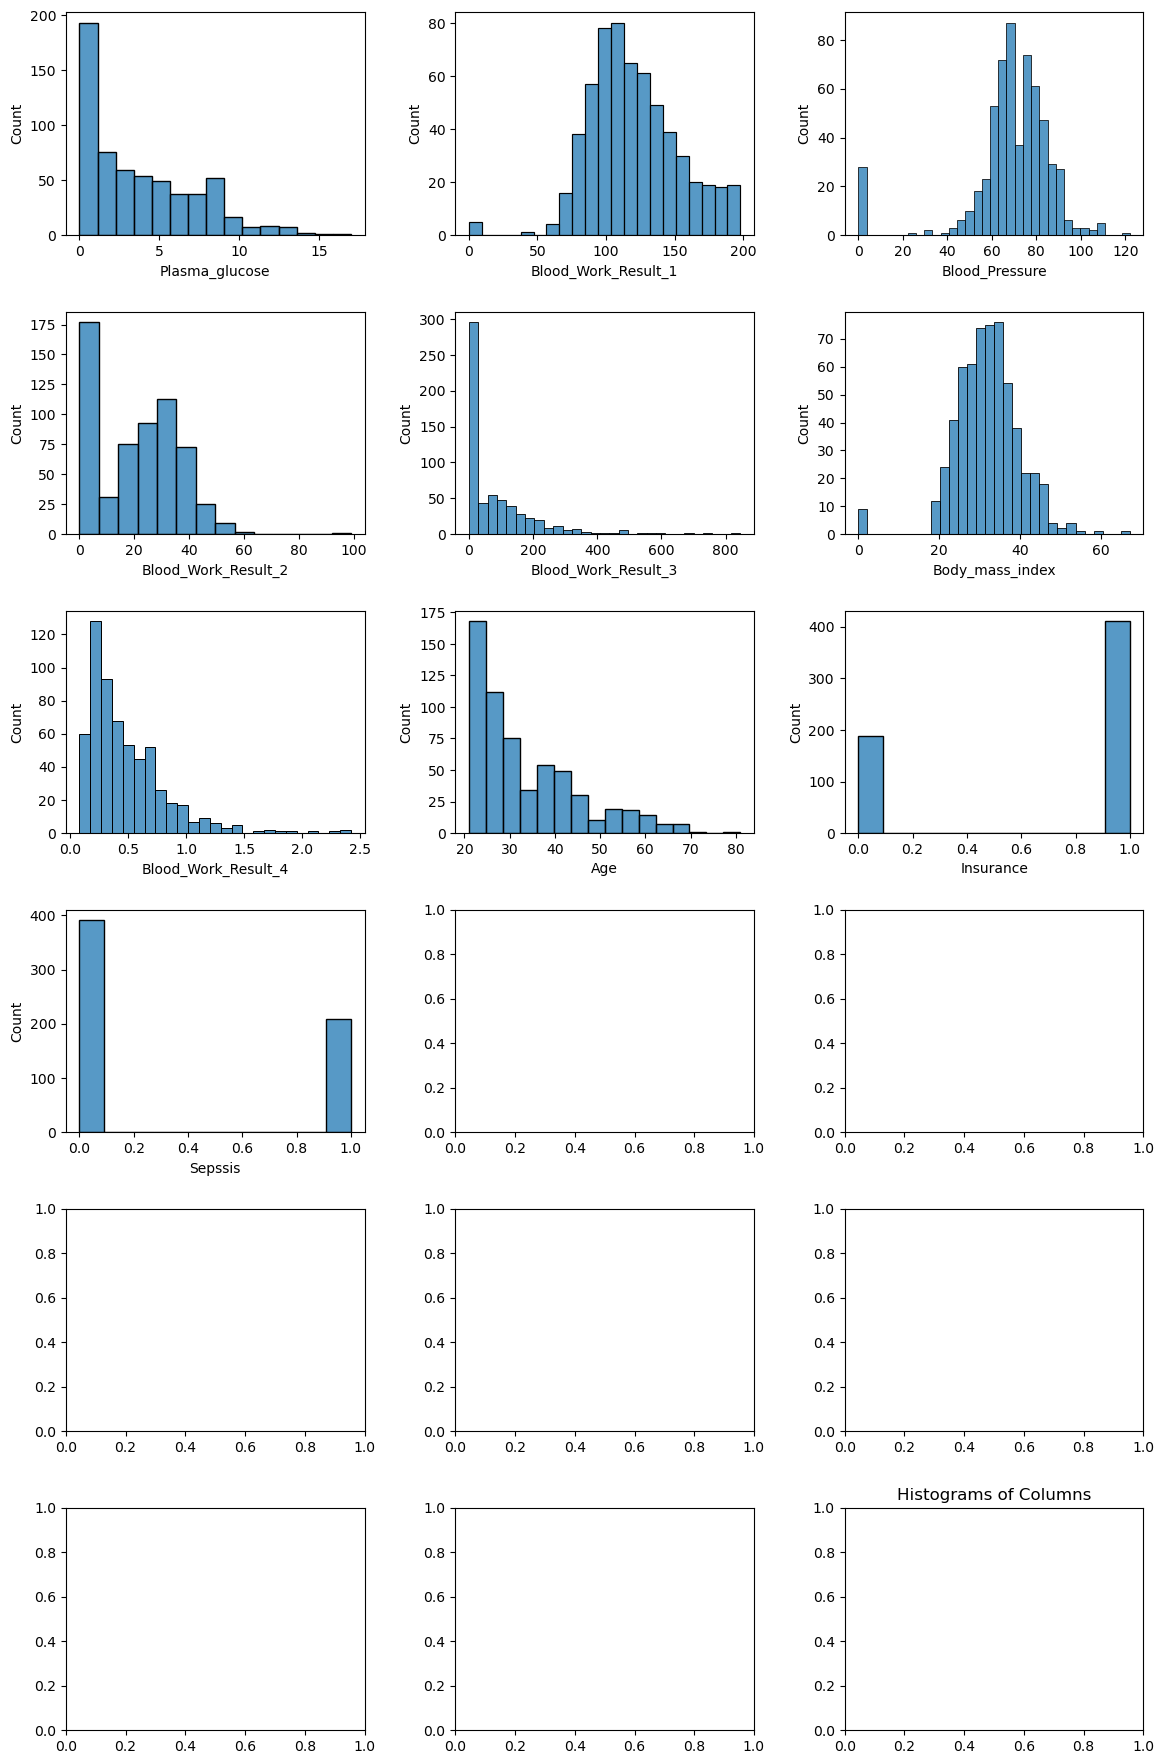

In [15]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 18))
axes = axes.reshape(-1)

continuous = [col for col in train_df.columns if train_df[col].dtype != object]
for i, col in enumerate(continuous):
    sns.histplot(train_df[col], ax=axes[i])

fig.tight_layout(pad=2.0)
plt.title('Histograms of Columns');

### Observations:
* Most features are normally distributed as expected

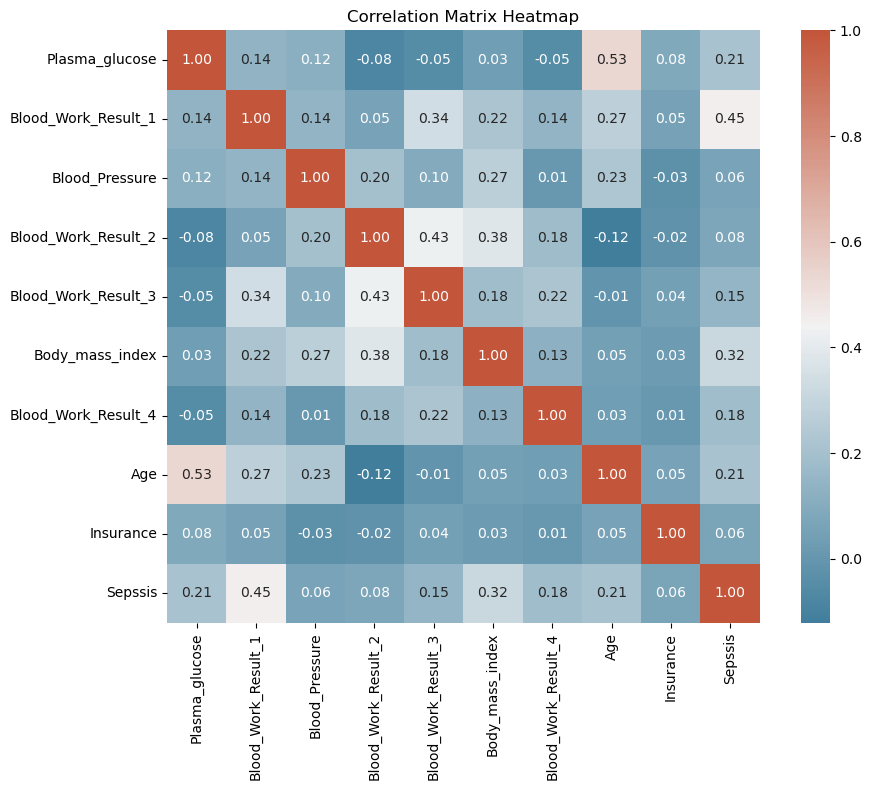

In [16]:
plt.figure(figsize=(10, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', square=True, cmap=cmap)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

## Modeling

In [17]:
train_df_final = train_df.copy()
X = train_df.drop(columns=['Sepssis','ID'])
y = train_df['Sepssis']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state=42)

print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])

Train size: 479
Test size:  120


In [18]:
y.value_counts()

0    391
1    208
Name: Sepssis, dtype: int64

* the data is unbalanced where the negative sepsis outcome is approximately twice that of the positive sepsis outcome

## Logistic Regression
### Baseline

In [19]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0], dtype=int64)

Confusion Matrix
-----------------------------------------------------


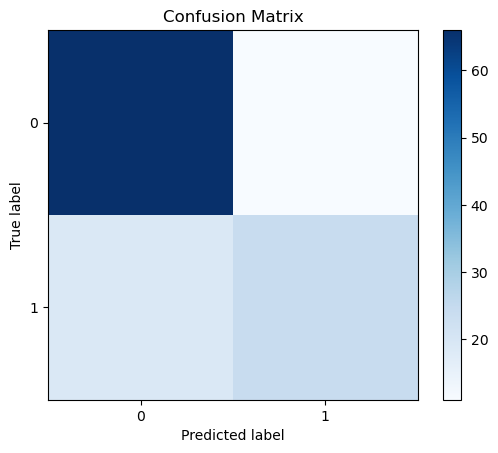



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.86      0.81        77
           1       0.69      0.56      0.62        43

    accuracy                           0.75       120
   macro avg       0.73      0.71      0.72       120
weighted avg       0.74      0.75      0.74       120



ROC Curve
-----------------------------------------------------


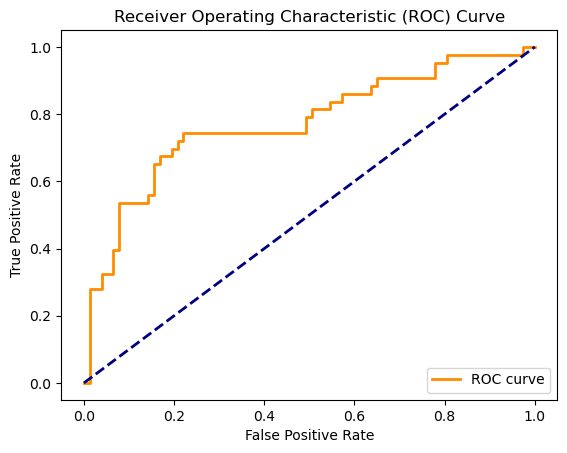



Checking model fitness
-----------------------------------------------------
Train score: 0.7724
Test score:  0.75




In [20]:
def conf_matrix(model, X_test, y_test, cmap='Blues'):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    classes = np.unique(y_test)
    plt.xticks(classes, classes)
    plt.yticks(classes, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.grid(False)  # Remove grid lines
    plt.show()

    
def roc_curve_custom(model, X_test, y_test):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred):
    # Confusion Matrix
    print('Confusion Matrix')
    print('-'*53)
    conf_matrix(model, X_test, y_test)
    print('\n') 
    
    # Classification Report
    print('Classification Report') 
    print('-'*53)
    print(classification_report(y_test, y_pred))
    print('\n')
    
    # ROC Curve
    print('ROC Curve')
    print('-'*53)
    roc_curve_custom(model, X_test, y_test)
    print('\n')
    
    # Checking model fitness
    print('Checking model fitness') 
    print('-'*53)
    print('Train score:', round(model.score(X_train, y_train), 4))
    print('Test score: ', round(model.score(X_test, y_test), 4))
    print('\n')
    
evaluate(logreg)

### Observations
* Decent performance for baseline model
* the model is well fit, with the training and test scores close to each other
* Precision is the weakest point, especially for cases where the individual has sepsis

## Hyperparameter Tuning

In [21]:
logreg_params = {
    'C': [1, 1e8, 1e16],
    'fit_intercept': [True, False],
    'max_iter': [50, 100, 150],
    'random_state': [42]
}

logreg_gs = GridSearchCV(logreg, logreg_params, scoring='accuracy', cv=3)
logreg_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [1, 100000000.0, 1e+16],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 150], 'random_state': [42]},
             scoring='accuracy')

In [22]:
logreg_gs.best_params_

{'C': 100000000.0, 'fit_intercept': True, 'max_iter': 150, 'random_state': 42}

In [23]:
round(logreg_gs.best_score_, 4)

0.7578

In [24]:
y_pred_logreg_gs = logreg_gs.predict(X_test)
y_pred_logreg_gs

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int64)

Confusion Matrix
-----------------------------------------------------


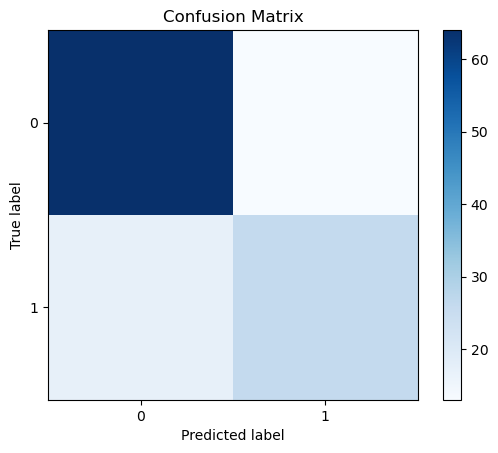



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.83      0.81        77
           1       0.67      0.60      0.63        43

    accuracy                           0.75       120
   macro avg       0.73      0.72      0.72       120
weighted avg       0.75      0.75      0.75       120



ROC Curve
-----------------------------------------------------


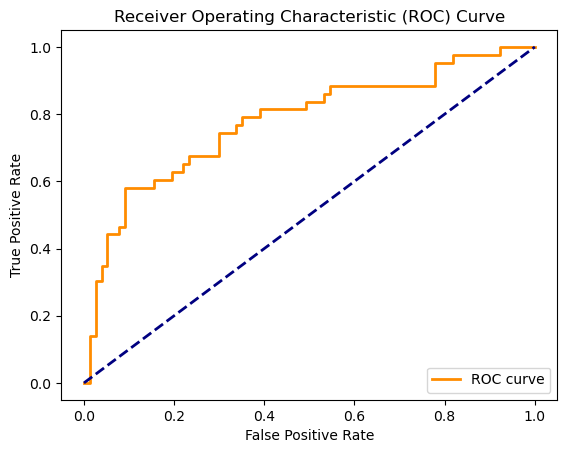



Checking model fitness
-----------------------------------------------------
Train score: 0.7871
Test score:  0.75




In [25]:
evaluate(logreg_gs, y_pred=y_pred_logreg_gs)

### Observations
* Slight Improvement in the precision and model fitness
* Overall, not much improvement over baseline logreg mode

## Correcting Class Imbalance
 
 A class imbalance exists for the target variable. Correcting for this may improve the model performance. We will resample the training data using SMOTE

In [ ]:
X_train_resampled, y_train_resampled = SMOTE().fit_resample(X_train, y_train)

print('Original')
print('-'*20)
print(y_train.value_counts())
print('\n')
print('SMOTE')
print('-'*20)
print(pd.Series(y_train_resampled).value_counts())

## Decision Tree
### Baseline

In [26]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
y_pred_tree

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0], dtype=int64)

Confusion Matrix
-----------------------------------------------------


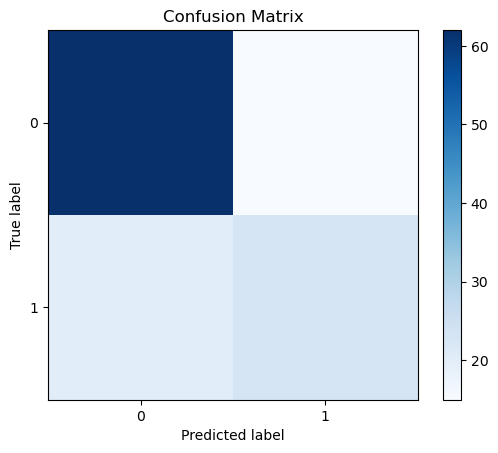



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.81      0.78        77
           1       0.61      0.53      0.57        43

    accuracy                           0.71       120
   macro avg       0.68      0.67      0.67       120
weighted avg       0.70      0.71      0.70       120



ROC Curve
-----------------------------------------------------


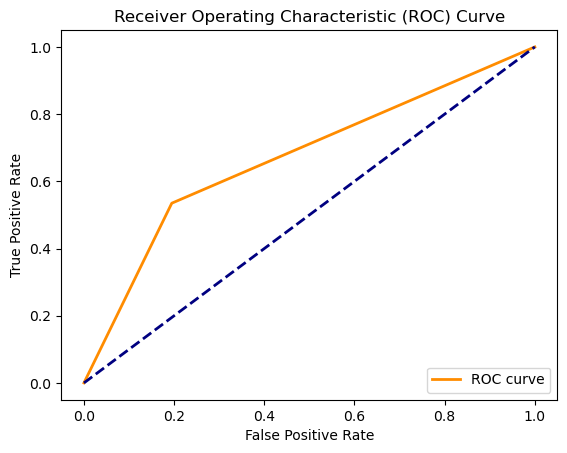



Checking model fitness
-----------------------------------------------------
Train score: 1.0
Test score:  0.7083




In [27]:
evaluate(clf, y_pred=y_pred_tree)

### Observations
* The accuracy is lower than the tuned logisitic regression model
* The model is overfit, given by the much higher score for the train data versus the test data

## Random Forest
### Baseline

In [28]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0], dtype=int64)

Confusion Matrix
-----------------------------------------------------


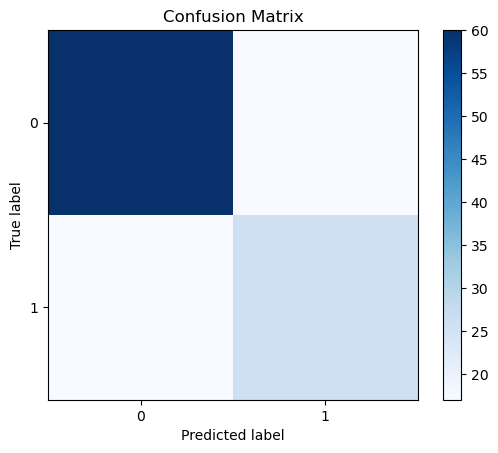



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        77
           1       0.60      0.60      0.60        43

    accuracy                           0.72       120
   macro avg       0.69      0.69      0.69       120
weighted avg       0.72      0.72      0.72       120



ROC Curve
-----------------------------------------------------


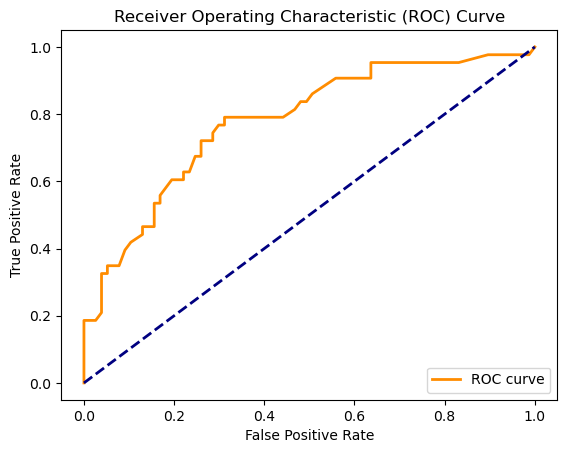



Checking model fitness
-----------------------------------------------------
Train score: 1.0
Test score:  0.7167




In [29]:
evaluate(rf, y_pred=y_pred_rf)

### Observations:

* Good scores on the evaluation metrics
* The model is a bit overfit

## Hyperparameter Tuning

In [30]:
rf_params = {
    'n_estimators': [10, 35, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 7, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'random_state': [42]
}

rf_gs = GridSearchCV(rf, param_grid=rf_params, scoring='accuracy', cv=3)
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 7, 11], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 35, 100], 'random_state': [42]},
             scoring='accuracy')

In [31]:
rf_gs.best_params_

{'criterion': 'gini',
 'max_depth': 11,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 100,
 'random_state': 42}

In [32]:
round(rf_gs.best_score_, 4)

0.7807

In [33]:
y_pred_rf_gs = rf_gs.predict(X_test)
y_pred_rf_gs

array([1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1], dtype=int64)

Confusion Matrix
-----------------------------------------------------


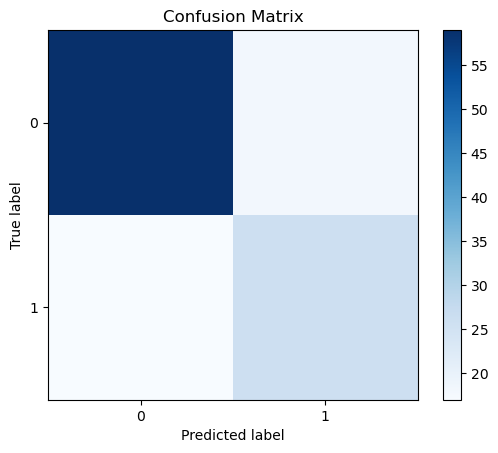



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.77      0.77        77
           1       0.59      0.60      0.60        43

    accuracy                           0.71       120
   macro avg       0.68      0.69      0.68       120
weighted avg       0.71      0.71      0.71       120



ROC Curve
-----------------------------------------------------


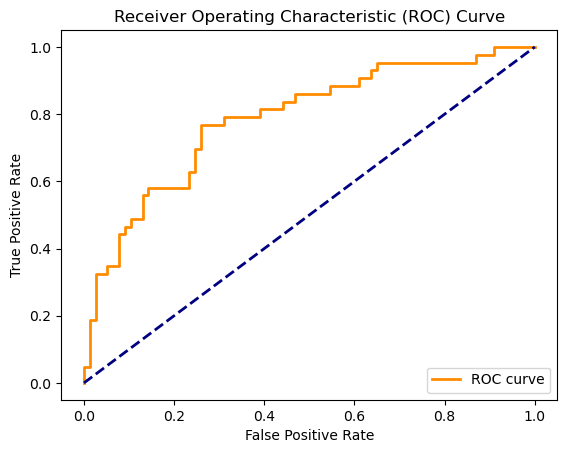



Checking model fitness
-----------------------------------------------------
Train score: 0.9332
Test score:  0.7083




In [34]:
evaluate(rf_gs, y_pred=y_pred_rf_gs)

## XGBoost
### Baseline

In [35]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_pred_xgb

array([0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

Confusion Matrix
-----------------------------------------------------


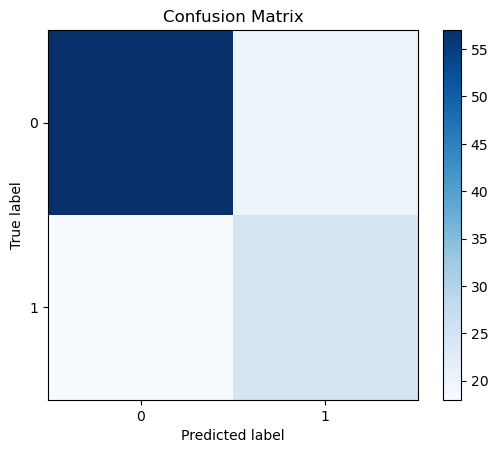



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.74      0.75        77
           1       0.56      0.58      0.57        43

    accuracy                           0.68       120
   macro avg       0.66      0.66      0.66       120
weighted avg       0.69      0.68      0.68       120



ROC Curve
-----------------------------------------------------


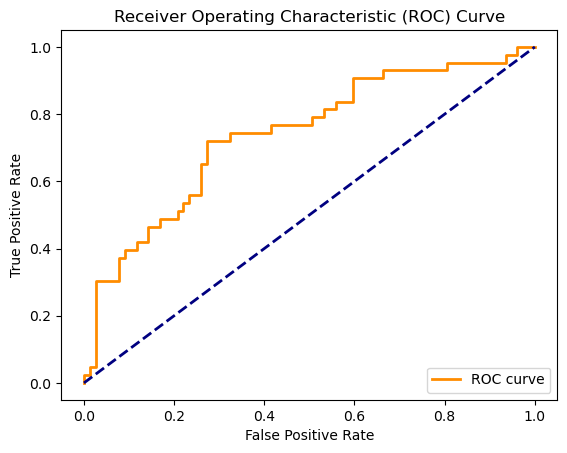



Checking model fitness
-----------------------------------------------------
Train score: 1.0
Test score:  0.6833




In [36]:
evaluate(xgb, y_pred=y_pred_xgb)

### Observations:

* Lowest accuracy score yet
* The model is overfit on the train set

## Model Comparisons

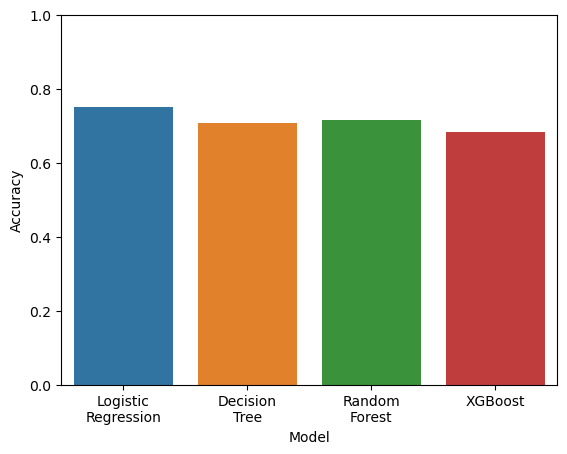

In [37]:
models = [logreg_gs, clf, rf, xgb]

# Create a list to store the accuracy scores
accuracies = [model.score(X_test, y_test) for model in models]

# Plot the bar chart
sns.barplot(x=['Logistic\nRegression', 'Decision\nTree', 'Random\nForest', 'XGBoost'],
            y=accuracies)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.0, 1.0)  # Set the y-axis limits to range from 0 to 1 (since accuracy is a percentage)
plt.show()

## Feature Importance

Since the tuned logistic regression model achieved the best results, I want to explore the feature importance a bit more in depth

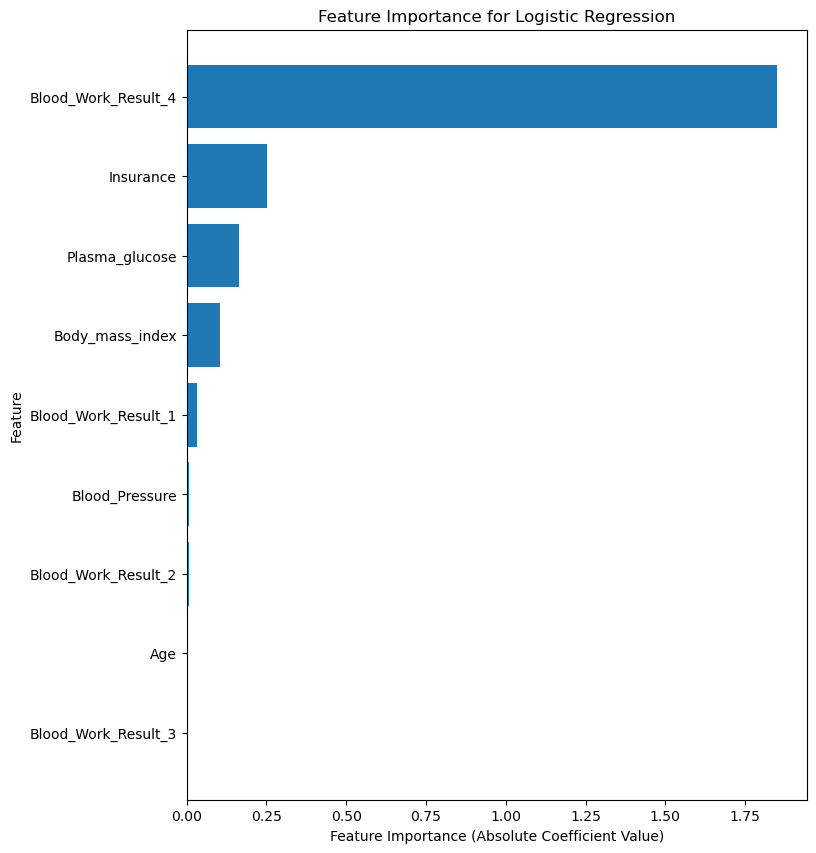

In [38]:
best_logreg = logreg_gs.best_estimator_

#  Larger absolute coefficients indicate more important features.
# Get the absolute coefficients and sort by importance
coef_importance = np.abs(best_logreg.coef_[0])
sorted_indices = np.argsort(coef_importance)

plt.figure(figsize=(8, 10))
plt.barh(range(len(coef_importance)), coef_importance[sorted_indices])
plt.yticks(range(len(coef_importance)), X_train.columns.values[sorted_indices])
plt.xlabel('Feature Importance (Absolute Coefficient Value)')
plt.ylabel('Feature')
plt.title('Feature Importance for Logistic Regression')
plt.show()


# we calculate the absolute value of the coefficients (coef_importance) and sort the features based on importance using np.argsort.
#Then, we create a horizontal bar plot using plt.barh, with the features on the y-axis and the importance on the x-axis.

## Conclusion
### Results

The best performing model is the hyperparameter-tuned Logistic Regression model with an accuracy of approximately 75%. The scores for both the training and testing data were similar, reducing concerns of the model being overfit. In terms of feature importances, Blood Work Result 4 is the single most important feature

In [43]:

model_file = open("models.pkl", "wb")  # Open a binary file for writing
pickle.dump(logreg_gs, model_file)  # Serialize the model and write it to the file
model_file.close()  # Close the file
